In [ ]:
#### The purpose of this Notebook is to implement UserDoc and Post Doc Method on basic public data Set.
#Note: At Various step matrix are generated and stored at local device while matrix are imported or loaded from local device
#Reason being any deep learning based model such as AutoEncoders are processed at Colab Notebook

In [1]:
import pandas as pd
import numpy as np
import re
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec
import random
import string
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy import spatial

In [2]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
lemmatizer = WordNetLemmatizer()

In [3]:
def convert2lower(inputstr):
    return inputstr.lower()

def removeNum(inputstr):
    return re.sub(r'\d+','',inputstr)

def removePunc(inputstr):
    for x in inputstr.lower(): 
        if x in punctuations: 
            inputstr = inputstr.replace(x, "")
    return inputstr

def removeWhiteSpace(inputstr):
    return inputstr.strip()

def removeStopWordsandLemmatize(inputstr):
    token = word_tokenize(inputstr)
    result = [i for i in token if not i in stop_words]
    result = [lemmatizer.lemmatize(i) for i in result]
    return ' '.join(result)

def CompletePreprocessingofWord(tweetlist):
    l = []
    for tweet in tweetlist:
        clean_tweet = convert2lower(tweet)
        clean_tweet = removeNum(clean_tweet)
        clean_tweet = removePunc(clean_tweet)
        clean_tweet = removeStopWordsandLemmatize(clean_tweet)
        clean_tweet = removeWhiteSpace(clean_tweet)
        l.append(clean_tweet)
    return l


In [74]:
    def getuniquehashtags(tweetlist):
        allhashtags = []
        for tweet in tweetlist:
            allhashtags.extend(re.findall(r"#(\w+)",str(tweet)))
        return list(set(allhashtags))
    
    def getUniqueMentionedUsers(tweetlist):
        allmentionedUser = []
        for tweet in tweetlist:
            allmentionedUser.extend(re.findall(r"@(\w+)",str(tweet)))
        return list(set(allmentionedUser))
    
    def getAllhashtags(tweetlist):
        allhashtags = []
        for tweet in tweetlist:
            allhashtags.extend(re.findall(r"#(\w+)",str(tweet)))
        return allhashtags
    
    def getAllMentionedUsers(tweetlist):
        allmentionedUser = []
        for tweet in tweetlist:
            allmentionedUser.extend(re.findall(r"@(\w+)",str(tweet)))
        return allmentionedUser
    
    def RemoveTags(tweetlist):
        clean_tweetlist = []
        for tweet in tweetlist:
            tweet = re.sub('@[^\s]+','',str(tweet))
            tweet = re.sub('#[^\s]+','',str(tweet))
            clean_tweetlist.append(tweet)
        return clean_tweetlist  
    
    def RemoveHTTP(tweetlist):
        l = []
        for tweet in tweetlist:    
            clean_tweet = re.match('(.*?)http.*?\s?(.*?)',str(tweet))
            if(clean_tweet):
                l.append(clean_tweet.group(1))
            else:
                l.append(tweet)
            #l.append(re.sub(r"http:\+","",str(tweet)))
        return l
    
    def RemoveHttps(tweetlist):
        l = []
        for tweet in tweetlist:    
            clean_tweet = re.match('(.*?)https.*?\s?(.*?)',str(tweet))
            if(clean_tweet):
                l.append(clean_tweet.group(1))
            else:
                l.append(tweet)
            #l.append(re.sub(r"http:\+","",str(tweet)))
        return l

    def RemoveWWW(tweetlist):
        l = []
        for tweet in tweetlist:    
            clean_tweet = re.match('(.*?)www.*?\s?(.*?)',str(tweet))
            if(clean_tweet):
                l.append(clean_tweet.group(1))
            else:
                l.append(tweet)
            #l.append(re.sub(r"http:\+","",str(tweet)))
        return l
    
    def DeEmojify(tweetlist):
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
        l = []
        for tweet in tweetlist:
            l.append(tweet.encode('ascii', 'ignore').decode('ascii'))
        return l
    
#Get user data on basis of minimum number of tweets per user, Since we will generate embedding based on user-doc at a tweet level
    def getCustomDataFramebylimits(df,lowerlimit):
        main_df = df
        main_df = main_df[main_df['UserName'].map(main_df['UserName'].value_counts()) > lowerlimit]
        Corp_df = pd.DataFrame({'author' : main_df['UserName'].unique()})
        Corp_df['alltweets'] = [list(set(main_df['Tweet'].loc[main_df['UserName'] == x['author']])) for _,x in Corp_df.iterrows()]
        Corp_df['Allhashtags'] = [getAllhashtags(x['alltweets']) for _,x in Corp_df.iterrows()]
        Corp_df['Uniquehashtags'] = [getuniquehashtags(x['alltweets']) for _,x in Corp_df.iterrows()]
        Corp_df['UniqueMentionedUsers'] = [getUniqueMentionedUsers(x['alltweets']) for _,x in Corp_df.iterrows()]
        Corp_df['AllMentionedUsers'] = [getAllMentionedUsers(x['alltweets']) for _,x in Corp_df.iterrows()]  
        Corp_df['selectedtweets'] = [DeEmojify(x['alltweets']) for _,x in Corp_df.iterrows()]
        Corp_df['selectedtweets'] = [RemoveHTTP(x['selectedtweets']) for _,x in Corp_df.iterrows()]
        Corp_df['selectedtweets'] = [RemoveHttps(x['selectedtweets']) for _,x in Corp_df.iterrows()]
        Corp_df['selectedtweets'] = [RemoveWWW(x['selectedtweets']) for _,x in Corp_df.iterrows()]
        Corp_df['selectedtweets'] = [CompletePreprocessingofWord(x['selectedtweets']) for _,x in Corp_df.iterrows()]
        Corp_df['selectedtweets'] = [RemoveTags(x['selectedtweets']) for _,x in Corp_df.iterrows()]   
        return Corp_df

In [7]:
######################USER2DOC MODEL##########################################

In [27]:
#The method will generate Embedding from the tweets using the pre-modified gensim model.
def GetvectorEmbedding(dataframe):
    Tweet2Vecmodel = Doc2Vec.load("Tweet2Vec_Final.model")
    Trainingdata_df = dataframe
    final_Matrix_ds = []
    tweetList = Trainingdata_df['selectedtweets'][0]
    random.shuffle(tweetList)
    tweetList = tweetList[0:20]
    final_Matrix_ds = []
    for tweet in tweetList:
        tweet = word_tokenize(tweet.lower())
        vec = Tweet2Vecmodel.infer_vector(tweet)
        final_Matrix_ds = np.concatenate((final_Matrix_ds,vec), axis = None)
    
    for _,x in Trainingdata_df.iterrows():
        tweetList = x['selectedtweets']
        if(len(tweetList) < 20):
            pass
        else:
            random.shuffle(tweetList)
            tweetList = tweetList[0:20]
            res = []
            for tweet in tweetList:
                tweet = word_tokenize(tweet.lower())
                vec = Tweet2Vecmodel.infer_vector(tweet)
                res = np.concatenate((res,vec), axis = None)
            #x['1000StackUserEmbb'] = res
            final_Matrix_ds = np.vstack((final_Matrix_ds,res))
    #print(Trainingdata_df.head())
    return final_Matrix_ds    

#This method generated user embedding from tweets and stores it in a Matrix Format in local---> to be used as a input to AutoEncoder
def ReadAndGenerateAutoencoderInputUserMatrix(csvname,filenametobegenerated):
    Savefilepath = "C:/Users/SHAHBAZ/ZS UserEmbedding/AutoEncoderInputUserMatrix/"
    Readfilepath =  "C:/Users/SHAHBAZ/Desktop/tweets/" + str(csvname) + ".csv"
    fileName = Savefilepath + str(filenametobegenerated) + "_UserDoc_Matrix.txt"
    
    Data_F = pd.read_csv(Readfilepath,encoding = "latin-1")
    Data_F = Data_F[['Username','Tweet Content']]
    Data_F.columns = ["UserName","Tweet"]
    data_df = getCustomDataFramebylimits(Data_F,20)
    
    if(data_df.shape[0] > 0):
        Data_UserDoc_matrix = GetvectorEmbedding(data_df)
        np.savetxt(fileName,Data_UserDoc_matrix,fmt='%.8f') 
    else:
        pass

#This method is used to read Matrix generated from the AutoEncoder these vectors are the user representations out of userdoc method
def OutputAutoEncoderUserMatrixtoEmbedding(fileName):
    ReadFilepath = "C:/Users/SHAHBAZ/ZS UserEmbedding/AutoEncoderOutputEmbeddingMatrix/" + str(fileName) + "EmbMat.txt"
    UserEmb = np.loadtxt(ReadFilepath)
    return UserEmb

In [9]:
########################## POSTDOC Method #########################################

In [22]:
#Since post Doc method generate embeddings from all the user data at once, this method generates embedding from pre-modified 
#model directly from the csv file(test data)

modelPostDoc2Vec = Doc2Vec.load("d2vFinal.model")
def GeneratingPostDocEmbeddingfromCSV(csvname):
    Readfilepath =  "C:/Users/SHAHBAZ/Desktop/tweets/" + str(csvname) + ".csv"
    Data_F = pd.read_csv(Readfilepath,encoding = "latin-1")
    Data_F = Data_F[['Username','Tweet Content']]
    Data_F.columns = ["UserName","Tweet"]
    data_df = getCustomDataFramebylimits(Data_F,20)
    
    UserEmbedding = []
    if(data_df.shape[0] > 0):
        for _,x in data_df.iterrows():
            if(len(x['selectedtweets']) < 20):
                pass
            else:
                random.shuffle(x['selectedtweets'])
                tweetlist = x['selectedtweets'][0:20]
                text = ' '.join(tweetlist)
                data = word_tokenize(text.lower())
                vector = modelPostDoc2Vec.infer_vector(data)
                UserEmbedding.append(vector)
    else:
        pass
    return UserEmbedding
    

In [11]:
# Below Methods are used to caculate similarity score between like category users 
#and similarity score(dissimilarity) between users from different category users 
# Higher the similarity score and lower the disimilarity score its better.

In [51]:
########################### For User Doc Approach ########################
def GetSimilarityMeanfromSimilarEmb(UserEmb):
    if(len(UserEmb) <= 2):
        return 1.0
    else:
        SimilarUserCosineList = []
        for i in range(1,len(UserEmb)):
            for j in range(i+1,len(UserEmb)):
                res = 1 - spatial.distance.cosine(UserEmb[i],UserEmb[j])
                SimilarUserCosineList.append(abs(res))
        mean = sum(SimilarUserCosineList) / len(SimilarUserCosineList)
        return mean
def GetSimilarityMeanfromDifferentEmb(UserEmb1,UserEmb2):
    DifferentUserCosineList = []
    for i in range(1,len(UserEmb1)):
        for j in range(1,len(UserEmb2)):
            res = 1 - spatial.distance.cosine(UserEmb1[i],UserEmb2[j])
            DifferentUserCosineList.append(abs(res))
    mean = sum(DifferentUserCosineList) / len(DifferentUserCosineList)
    return mean

In [52]:
###################################For PostDoc Method#############################
def GetPosDocSimilarityMeanfromSimilarEmb(UserEmb):
    SimilarUserCosineList = []
    if(len(UserEmb) == 1):
        return 1.0
    for i in range(len(UserEmb)):
        for j in range(i+1,len(UserEmb)):
            res = 1 - spatial.distance.cosine(UserEmb[i],UserEmb[j])
            SimilarUserCosineList.append(abs(res))
    mean = sum(SimilarUserCosineList) / len(SimilarUserCosineList)
    return mean
def GetPosDocSimilarityMeanfromDifferentEmb(UserEmb1,UserEmb2):
    DifferentUserCosineList = []
    for i in range(len(UserEmb1)):
        for j in range(len(UserEmb2)):
            res = 1 - spatial.distance.cosine(UserEmb1[i],UserEmb2[j])
            DifferentUserCosineList.append(abs(res))
    mean = sum(DifferentUserCosineList) / len(DifferentUserCosineList)
    return mean

In [14]:
######################## Visualisation #################
#Below method is used for Visualisation Purpose, in order to create data set for TSNE visualisation

In [43]:
labellist = []
tokenlist = []
def preparedataforTsne(UserEmbedding,label,tokenlist):
    for x in UserEmbedding:
        labellist.append(label)
        tokenlist.append(x)
    return tokenlist

# 2 more methods to plot 

In [20]:
###############Data for AutoEncoder Training ######################

In [21]:
Data_F = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding = "latin-1")
Data_F = Data_F[Data_F.columns[4:6]]
Data_F.columns = ["UserName","Tweet"]

In [31]:
data_df = getCustomDataFramebylimits(Data_F,20)

In [33]:
TrainingMatrix = GetvectorEmbedding(data_df)

In [35]:
# Save matrix to train AutoEncoder model for reducing Embedding out of User Doc Method. 
#This matrix will act as input to AutoEncoder
np.savetxt('TrainingAutoEncoderMat.txt',TrainingMatrix,fmt='%.8f')

In [28]:
######################Creating User2Doc input for Autoencoder###########
ReadAndGenerateAutoencoderInputUserMatrix('adriande','adriande')

In [41]:
ReadAndGenerateAutoencoderInputUserMatrix('BBC','BBC')
ReadAndGenerateAutoencoderInputUserMatrix('billgates','billgates')
ReadAndGenerateAutoencoderInputUserMatrix('britneyspears','britneyspears')
ReadAndGenerateAutoencoderInputUserMatrix('bruno','bruno')
ReadAndGenerateAutoencoderInputUserMatrix('cnn','cnn')
ReadAndGenerateAutoencoderInputUserMatrix('Cr7','Cr7')
ReadAndGenerateAutoencoderInputUserMatrix('drake','drake')
ReadAndGenerateAutoencoderInputUserMatrix('espn','espn')
ReadAndGenerateAutoencoderInputUserMatrix('fcbarca','fcbarca')
ReadAndGenerateAutoencoderInputUserMatrix('harrystyles','harrystyles')
ReadAndGenerateAutoencoderInputUserMatrix('iamSrk','iamSrk')
ReadAndGenerateAutoencoderInputUserMatrix('instagram','instagram')
ReadAndGenerateAutoencoderInputUserMatrix('Nasa','Nasa')
ReadAndGenerateAutoencoderInputUserMatrix('nytimes','nytimes')
ReadAndGenerateAutoencoderInputUserMatrix('obama','obama')
ReadAndGenerateAutoencoderInputUserMatrix('realMad','realMad')
ReadAndGenerateAutoencoderInputUserMatrix('salman','salman')
ReadAndGenerateAutoencoderInputUserMatrix('sportscenter','sportscenter')


In [42]:
ReadAndGenerateAutoencoderInputUserMatrix('srbachan','srbachan')
ReadAndGenerateAutoencoderInputUserMatrix('trump','trump')
ReadAndGenerateAutoencoderInputUserMatrix('twitter','twitter')
ReadAndGenerateAutoencoderInputUserMatrix('virat','virat')
ReadAndGenerateAutoencoderInputUserMatrix('youtube','youtube')

In [ ]:
################################ Reading and Storing AutoEncoder Output for Evaluation ################

In [30]:
Name_list = ['adriande','akshay','BBC','billgates','britneyspears','bruno','cnn','Cr7','drake','espn','fcbarca','harrystyles','iamSrk','instagram','Nasa','nytimes','obama','realMad','salman','sportscenter','srbachan','trump','twitter','virat','youtube']

In [31]:
AutoEncoderOutputEmbedding = {}
for name in Name_list:
    AutoEncoderOutputEmbedding[name] = OutputAutoEncoderUserMatrixtoEmbedding(name)


In [62]:
################################ Reading and Storing Post Doc Embedding###########################
PostDocOutputEmbedding = {}
for name in Name_list:
    PostDocOutputEmbedding[name] = GeneratingPostDocEmbeddingfromCSV(name)

In [53]:
###################Measuring Similarity index for Autoencoder for all the users#############
User2DocSimilaritySameUser = {}  #0.9343221817852858
for name in Name_list:
    User2DocSimilaritySameUser[name] = GetSimilarityMeanfromSimilarEmb(AutoEncoderOutputEmbedding[name])

In [54]:
User2DocSimilaritySameUser 

{'adriande': 1.0,
 'akshay': 0.8568922398810229,
 'BBC': 0.8045201815441947,
 'billgates': 0.8718301116807995,
 'britneyspears': 0.8628684092935355,
 'bruno': 1.0,
 'cnn': 0.798704026754035,
 'Cr7': 1.0,
 'drake': 0.8699838490192575,
 'espn': 0.8259762391592078,
 'fcbarca': 1.0,
 'harrystyles': 1.0,
 'iamSrk': 0.9598100744967796,
 'instagram': 1.0,
 'Nasa': 0.9208997726941359,
 'nytimes': 0.9285012039885099,
 'obama': 0.8650680881475014,
 'realMad': 0.6059265687241646,
 'salman': 1.0,
 'sportscenter': 0.8269920202846448,
 'srbachan': 0.7896461807967154,
 'trump': 0.8529594215009665,
 'twitter': 1.0,
 'virat': 1.0,
 'youtube': 0.9026380757771347}

In [63]:
#################Measuring Similarity index for PostDoc Method for all users ###############
PostDocSimilaritySameUser = {}     #0.8383405867857305
for name in Name_list:
    PostDocSimilaritySameUser[name] = GetPosDocSimilarityMeanfromSimilarEmb(PostDocOutputEmbedding[name])

In [55]:
########################### Calculating similarity between different categories for AutoEncoder #########
Main_dic_userDoc = {}   #This dictionary stores mean similarity score of a user category with all other categories. 
for main_name in Name_list:
    differentUsersimilarity = {}
    for name in Name_list:
        if(name == main_name):
            pass
        else:
            differentUsersimilarity[name] = GetSimilarityMeanfromDifferentEmb(AutoEncoderOutputEmbedding[main_name],AutoEncoderOutputEmbedding[name])
    Main_dic_userDoc[main_name] = differentUsersimilarity


In [68]:
#########Calculation of difference in Similarity of UserEmbedding for same and different categry for User2Doc#########
Difference_inSimilarityScore ={}
for main_name in Name_list:
    SimilarUserScore = User2DocSimilaritySameUser[main_name]
    sum_of_difference = 0
    dic = Main_dic_userDoc[main_name]
    count = 0
    for name in Name_list:
        if (name == main_name):
            pass
        else:  
            s = abs(SimilarUserScore - dic[name])
            sum_of_difference = sum_of_difference + s
    Difference_inSimilarityScore[main_name] = sum_of_difference / (24 - count)


adriande:::0
akshay:::0
BBC:::0
billgates:::0
britneyspears:::0
bruno:::0
cnn:::0
Cr7:::0
drake:::0
espn:::0
fcbarca:::0
harrystyles:::0
iamSrk:::0
instagram:::0
Nasa:::0
nytimes:::0
obama:::0
realMad:::0
salman:::0
sportscenter:::0
srbachan:::0
trump:::0
twitter:::0
virat:::0
youtube:::0


In [70]:
#############Measuring the Mean ##############
s = 0
for x in Name_list:
    if(x == 'realMad'):
        pass
    else:
        s = s + Difference_inSimilarityScore[x]                     #0.0022735917453390194
s / 25

0.08733069096220597

In [65]:
########################### Calculating similarity between different categories for Post2Doc ############
Main_dic_PostDoc = {}
for main_name in Name_list:
    differentUsersimilarity = {}
    for name in Name_list:
        if(name == main_name):
            pass
        else:
            differentUsersimilarity[name] = GetPosDocSimilarityMeanfromDifferentEmb(PostDocOutputEmbedding[main_name],PostDocOutputEmbedding[name])
    Main_dic_PostDoc[main_name] = differentUsersimilarity

In [71]:
#########Calculation of difference in Similarity of UserEmbedding for same and different categry for PostDoc#########
Difference_inSimilarityScore_PostDoc ={}
for main_name in Name_list:
    SimilarUserScore = PostDocSimilaritySameUser[main_name]
    sum_of_difference = 0
    dic = Main_dic_PostDoc[main_name]
    count = 0
    for name in Name_list:
        if (name == main_name):
            pass
        else:  
            s = abs(SimilarUserScore - dic[name])
            sum_of_difference = sum_of_difference + s
    Difference_inSimilarityScore_PostDoc[main_name] = sum_of_difference / (24 - count)

adriande___0
akshay___0
BBC___0
billgates___0
britneyspears___0
bruno___0
cnn___0
Cr7___0
drake___0
espn___0
fcbarca___0
harrystyles___0
iamSrk___0
instagram___0
Nasa___0
nytimes___0
obama___0
realMad___0
salman___0
sportscenter___0
srbachan___0
trump___0
twitter___0
virat___0
youtube___0


In [72]:
#############Measuring the Mean ##############
s = 0
for x in Name_list:                                  #0.005545574509197308
    s = s + Difference_inSimilarityScore_PostDoc[x]
s / 25

0.24381400695797203

In [42]:
############### Visualisation of Embedding #################

In [78]:
#AutoEncoder User2Doc 
tokenlist = []
labellist = []

for name in Name_list:
    tokenlist = preparedataforTsne(AutoEncoderOutputEmbedding[name],name,tokenlist)


In [79]:
tsne_model = TSNE(perplexity = 50,n_components=2,init='pca',n_iter=2500, random_state = 23)
new_values = tsne_model.fit_transform(tokenlist)
x_cord = []
y_cord = []

for value in new_values:
    x_cord.append(value[0])
    y_cord.append(value[1])

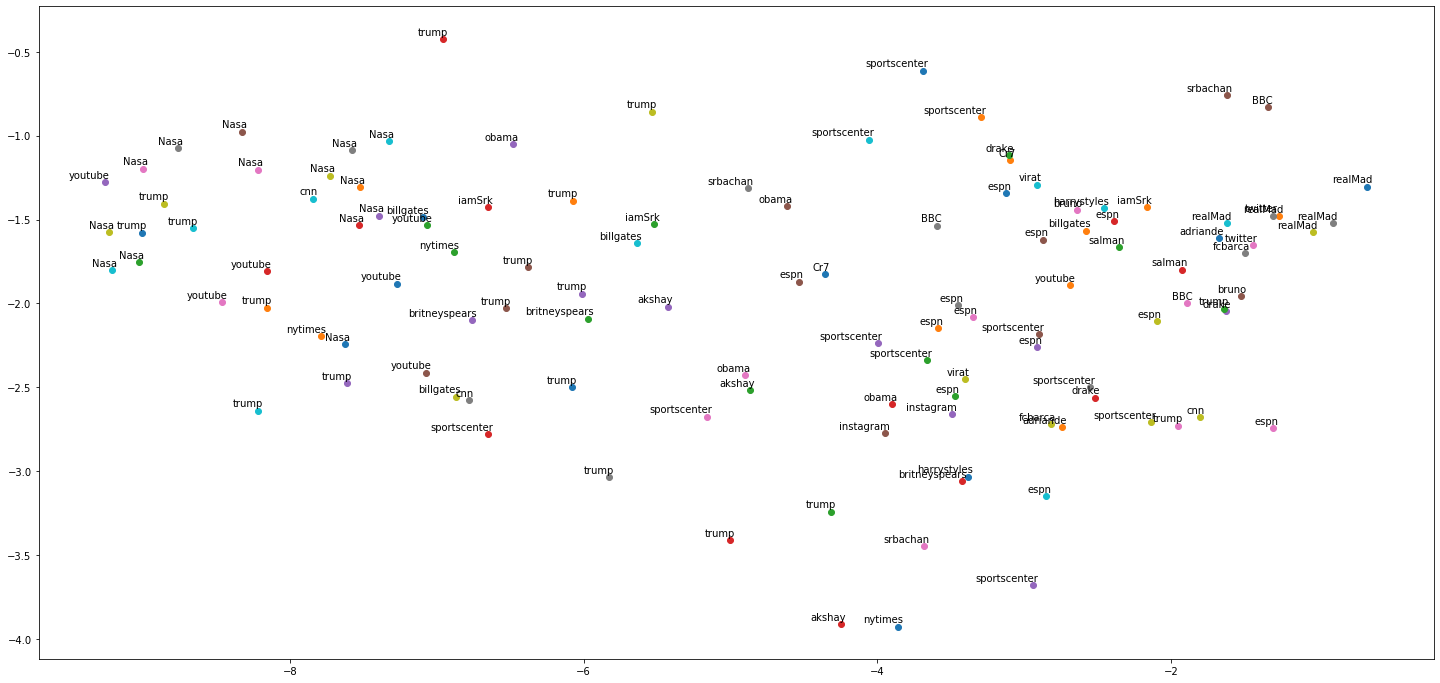

In [81]:
plt.figure(figsize=(25, 12)) 
for i in range(len(x_cord)):
    plt.scatter(x_cord[i],y_cord[i])
    plt.annotate(labellist[i],xy=(x_cord[i], y_cord[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
plt.show()

In [82]:
#PostDc
tokenlist = []
labellist = []

for name in Name_list:
    tokenlist = preparedataforTsne(PostDocOutputEmbedding[name],name,tokenlist)


In [83]:
tsne_model = TSNE(perplexity = 50,n_components=2,init='pca',n_iter=2500, random_state = 23)
new_values = tsne_model.fit_transform(tokenlist)
x_cord = []
y_cord = []

for value in new_values:
    x_cord.append(value[0])
    y_cord.append(value[1])

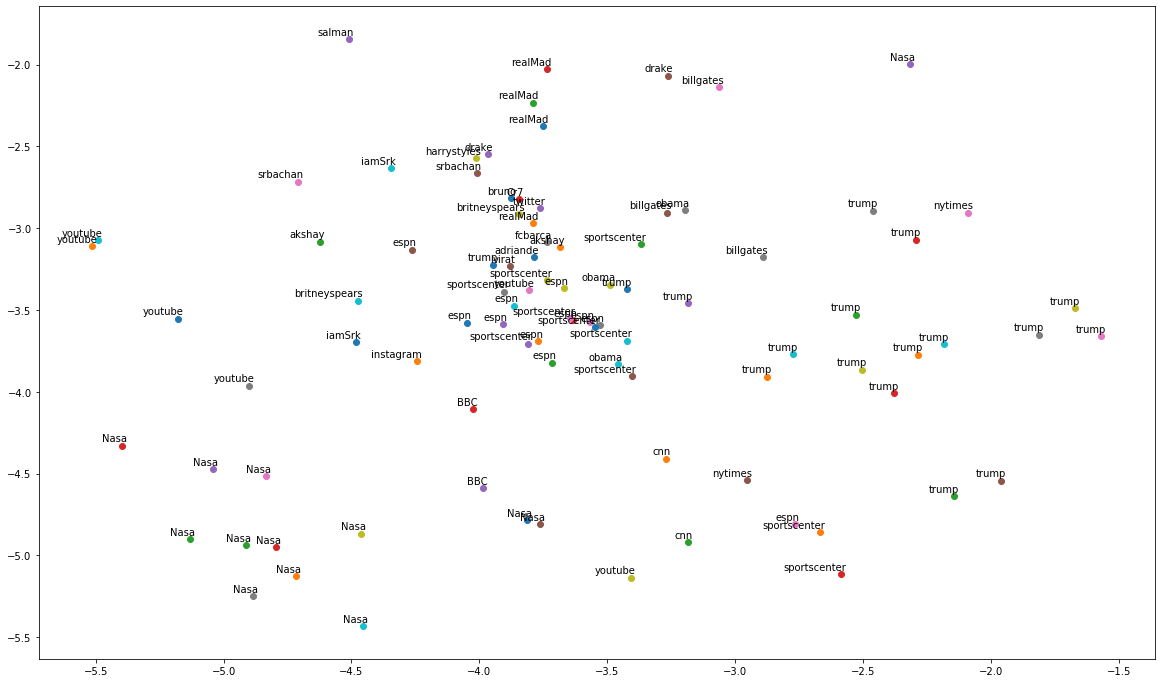

In [86]:
plt.figure(figsize=(20, 12)) 
for i in range(len(x_cord)):
    plt.scatter(x_cord[i],y_cord[i])
    plt.annotate(labellist[i],xy=(x_cord[i], y_cord[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
plt.show()

In [4]:
##### PostDoc on CardioLogy DataSet ########
Main_df = pd.read_csv('C:/Users/SHAHBAZ/ZS UserEmbedding/BERT Embedding/MainDF.csv')
Main_df = Main_df[["AUTHOR_ID","TRANS_AUTHOR_BIO","Snippet"]]

In [6]:
modelPostDoc2Vec = Doc2Vec.load("d2vFinal.model")

In [8]:
Mat_PostDoc_Basic = np.zeros(600)
count = 1
for _,x in Main_df.iterrows():
    author_info = x['TRANS_AUTHOR_BIO']
    author_info_emb = modelPostDoc2Vec.infer_vector(word_tokenize(author_info.lower()))
    tweetList = x['Snippet']
    tweet_text = ''
    for tweet in tweetList:
        tweet_text = ' '.join(tweet)
    tweet_emb = modelPostDoc2Vec.infer_vector(word_tokenize(tweet_text.lower()))
    vec = []
    vec = np.concatenate((tweet_emb,author_info_emb), axis=None)
    Mat_PostDoc_Basic = np.vstack((Mat_PostDoc_Basic,vec))
    print("Epoch " + str(count) + " / 6000")
    count = count + 1

Epoch 1 / 6000
Epoch 2 / 6000
Epoch 3 / 6000
Epoch 4 / 6000
Epoch 5 / 6000
Epoch 6 / 6000
Epoch 7 / 6000
Epoch 8 / 6000
Epoch 9 / 6000
Epoch 10 / 6000
Epoch 11 / 6000
Epoch 12 / 6000
Epoch 13 / 6000
Epoch 14 / 6000
Epoch 15 / 6000
Epoch 16 / 6000
Epoch 17 / 6000
Epoch 18 / 6000
Epoch 19 / 6000
Epoch 20 / 6000
Epoch 21 / 6000
Epoch 22 / 6000
Epoch 23 / 6000
Epoch 24 / 6000
Epoch 25 / 6000
Epoch 26 / 6000
Epoch 27 / 6000
Epoch 28 / 6000
Epoch 29 / 6000
Epoch 30 / 6000
Epoch 31 / 6000
Epoch 32 / 6000
Epoch 33 / 6000
Epoch 34 / 6000
Epoch 35 / 6000
Epoch 36 / 6000
Epoch 37 / 6000
Epoch 38 / 6000
Epoch 39 / 6000
Epoch 40 / 6000
Epoch 41 / 6000
Epoch 42 / 6000
Epoch 43 / 6000
Epoch 44 / 6000
Epoch 45 / 6000
Epoch 46 / 6000
Epoch 47 / 6000
Epoch 48 / 6000
Epoch 49 / 6000
Epoch 50 / 6000
Epoch 51 / 6000
Epoch 52 / 6000
Epoch 53 / 6000
Epoch 54 / 6000
Epoch 55 / 6000
Epoch 56 / 6000
Epoch 57 / 6000
Epoch 58 / 6000
Epoch 59 / 6000
Epoch 60 / 6000
Epoch 61 / 6000
Epoch 62 / 6000
Epoch 63 / 6000
E

In [9]:
Savefilepath = "C:/Users/SHAHBAZ/ZS UserEmbedding/AutoEncoderInputUserMatrix/"
fileName = Savefilepath + "PostDoc_Basic_Matrix.txt"
Mat_PostDoc_Basic = Mat_PostDoc_Basic[1:,:]
np.savetxt(fileName,Mat_PostDoc_Basic,fmt='%.8f') 